<a href="https://colab.research.google.com/github/VamuveTV/AVISubDetector/blob/main/split_then_refine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Colab contains the Official demo of our AAAI21 paper:

[**Split then Refine: Stacked Attention-guided ResUNets for Blind Single Image Visible Watermark Removal**](https://arxiv.org/abs/2012.07007)

Xiaodong Cun, Chi-Man Pun*

University of Macau

In [ ]:
# download the necessary componments
! rm -rf *
! git clone https://github.com/vinthony/deep-blind-watermark-removal.git # get code from github
! gdown https://drive.google.com/uc?id=1KpSJ6385CHN6WlAINqB3CYrJdleQTJBc # get pretrained model
! gdown https://drive.google.com/uc?id=18HaWfYYZCD34VttSjd2at8b9BKdhgVgU && unzip -q val.zip # get validation dataset (2.31G) of 27kpng
! gdown https://drive.google.com/uc?id=1it5oQDRqRzBVieX6jKNmOxj1992f63yM && unzip -q natural.zip # get natural images (0.4G) of 27kpng

# rename natural images
from os import listdir
from os.path import isfile, join
import shutil
filenames = [ shutil.copy(join('./natural', f), join('./natural', f).split('-')[0]+'.jpg') for f in listdir('./natural') if isfile(join('./natural', f)) ]

Cloning into 'deep-blind-watermark-removal'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 89 (delta 25), reused 56 (delta 11), pack-reused 0
Unpacking objects: 100% (89/89), done.
Downloading...
From: https://drive.google.com/uc?id=1KpSJ6385CHN6WlAINqB3CYrJdleQTJBc
To: /content/27kpng_model_best.pth.tar
100% 131M/131M [00:02<00:00, 59.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=18HaWfYYZCD34VttSjd2at8b9BKdhgVgU
To: /content/val.zip
100% 2.31G/2.31G [00:22<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=1it5oQDRqRzBVieX6jKNmOxj1992f63yM
To: /content/natural.zip
100% 443M/443M [00:06<00:00, 69.5MB/s]


total Dataset of val_images is :  3
input          | target              | coarser            | final
----------------------------------------------------------------------------
predicted mask | predicted watermark | coarser difference | final difference


/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


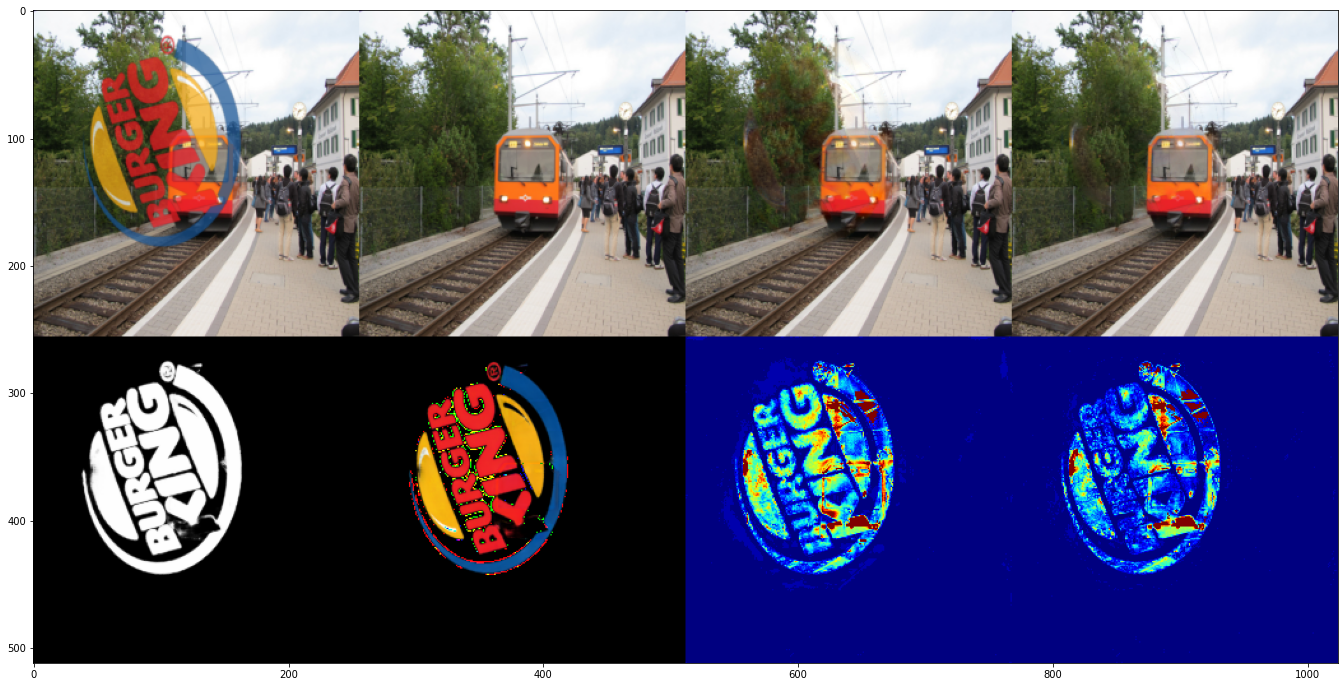

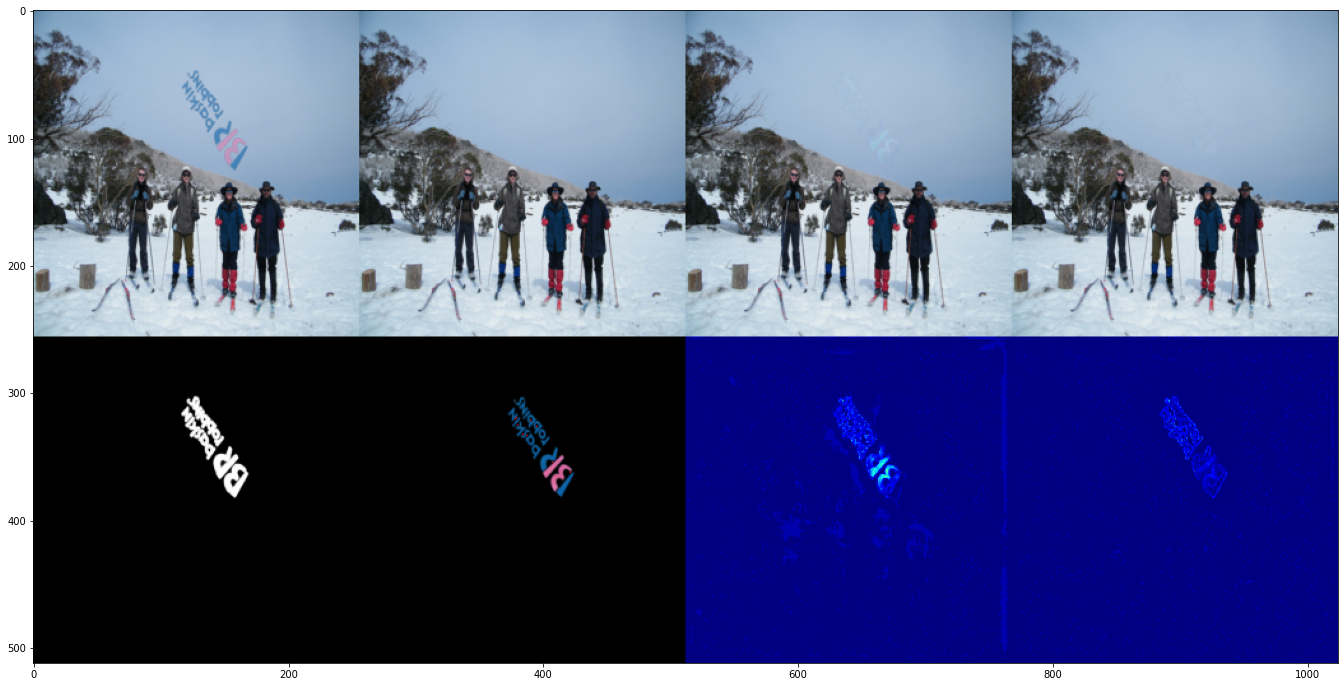

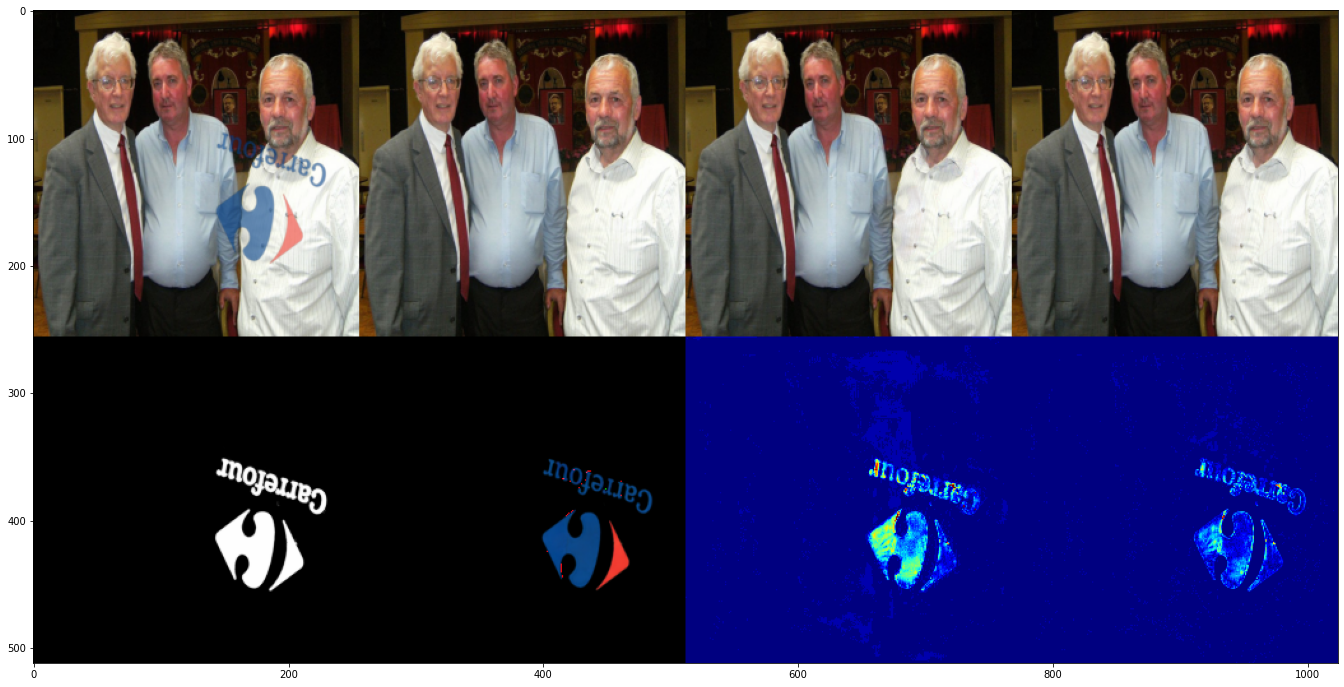

In [ ]:
import os, sys, torch,random
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

sys.path.append('deep-blind-watermark-removal')
sys.path.insert(0,'deep-blind-watermark-removal')

from scripts.utils.imutils import im_to_numpy
import scripts.models as models
import scripts.datasets as datasets
%matplotlib inline
from PIL import Image, ImageChops

def get_jet():
    colormap_int = np.zeros((256, 3), np.uint8)

    for i in range(0, 256, 1):
        colormap_int[i, 0] = np.int_(np.round(cm.jet(i)[0] * 255.0))
        colormap_int[i, 1] = np.int_(np.round(cm.jet(i)[1] * 255.0))
        colormap_int[i, 2] = np.int_(np.round(cm.jet(i)[2] * 255.0))

    return colormap_int

def clamp(num, min_value, max_value):
    return max(min(num, max_value), min_value)

def gray2color(gray_array, color_map):

    rows, cols = gray_array.shape
    color_array = np.zeros((rows, cols, 3), np.uint8)

    for i in range(0, rows):
        for j in range(0, cols):
#             log(256,2) = 8 , log(1,2) = 0 * 8
            color_array[i, j] = color_map[clamp(int(abs(gray_array[i, j])*10),0,255)]

    return color_array

class objectview(object):
    def __init__(self, *args, **kwargs):
        d = dict(*args, **kwargs)
        self.__dict__ = d

jet_map = get_jet()

resume_path = '27kpng_model_best.pth.tar' # path of pretrained model
samples = [320,1364,1868] #random.sample(range(4000), 1) # show random sample

data_config  = objectview({'input_size':256,
                            'limited_dataset':0,
                            'normalized_input':False,
                            'data_augumentation':False,
                            'base_dir':'.',
                            'data':'_images'})

val_loader = torch.utils.data.DataLoader(datasets.COCO('val',config=data_config,sample=samples))

print('input          | target              | coarser            | final')
print('----------------------------------------------------------------------------')
print('predicted mask | predicted watermark | coarser difference | final difference')

with torch.no_grad():

      model = models.__dict__['vvv4n']().cuda()
      model.load_state_dict(torch.load(resume_path)['state_dict'])
      model.eval()

      for i, batches in enumerate(val_loader):

          plt.figure(figsize=(48,12))

          im,mask,target = batches['image'].cuda(),batches['mask'].cuda(),batches['target'].cuda()

          imoutput,immask,imwatermark = model(im)

          imcoarser,imrefine,imwatermark = imoutput[1]*immask + im*(1-immask),imoutput[0]*immask + im*(1-immask),imwatermark*immask

          ims1 = im_to_numpy(torch.clamp(torch.cat([im,target,imcoarser,imrefine],dim=3)[0]*255,min=0.0,max=255.0)).astype(np.uint8)

          imcoarser, imrefine, target  = im_to_numpy((imcoarser[0]*255)).astype(np.uint8), im_to_numpy((imrefine[0]*255)).astype(np.uint8), im_to_numpy((target[0]*255)).astype(np.uint8)
          immask, imwatermark = im_to_numpy((immask.repeat(1,3,1,1)[0]*255)).astype(np.uint8),im_to_numpy((imwatermark[0]*255)).astype(np.uint8)

          coarsenp = gray2color(np.array(ImageChops.difference(Image.fromarray(imcoarser),Image.fromarray(target)).convert('L')),jet_map)
          finenp = gray2color(np.array(ImageChops.difference(Image.fromarray(imrefine),Image.fromarray(target)).convert('L')),jet_map)

          imfinal = np.concatenate([ims1,np.concatenate([immask,imwatermark,coarsenp,finenp],axis=1)],axis=0)

          plt.imshow(imfinal,vmin=0.0,vmax=255.0)
